# Pneumonia

Pneumonia is a lung infection that can range from mild to so severe that you have to go to the hospital.It happens when an infection causes the air sacs in your lungs (your doctor will call them alveoli) to fill with fluid or pus. That can make it hard for you to breathe in enough oxygen to reach your bloodstream.

Anyone can get this lung infection. But infants younger than age 2 and people over age 65 are at higher risk. That’s because their immune systems might not be strong enough to fight it.

You can get pneumonia in one or both lungs. You can also have it and not know it. Doctors call this walking pneumonia. Causes include bacteria, viruses, and fungi.  If your pneumonia results from bacteria or a virus, you can spread it to someone else. 

Lifestyle habits, like smoking cigarettes and drinking too much alcohol, can also raise your chances of getting pneumonia.

# Import libraries and download datasets


In [ ]:
import cv2
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator #loading the data from folder
import os, random
from google.colab.patches import cv2_imshow #displaying an image
import pandas as pd #data manipulation and analysis
import numpy as np #array manipulation and linear algebra
import string
from tensorflow.keras.layers import Dense,Conv2D,Resizing,MaxPooling2D,Flatten,Input,Rescaling,Dropout,Activation,BatchNormalization
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
#install kaggle
! pip install -q kaggle

In [ ]:
#load the file containing the key
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohamedbenmaiza","key":"7637731167f99e3dab4d2e484909135d"}'}

In [ ]:
 ! mkdir ~/.kaggle 

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#download the dataset from kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:57<00:00, 63.0MB/s]
100% 2.29G/2.29G [00:57<00:00, 42.9MB/s]


In [ ]:
#uziping the folder
! unzip  /content/chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

# Exploring the data

In [ ]:
img=cv2.imread("/content/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
img.shape

(1858, 2090, 3)

In [ ]:
img=cv2.imread("/content/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")
img.shape

(760, 1152, 3)

its clear that the images have diffrent shapes

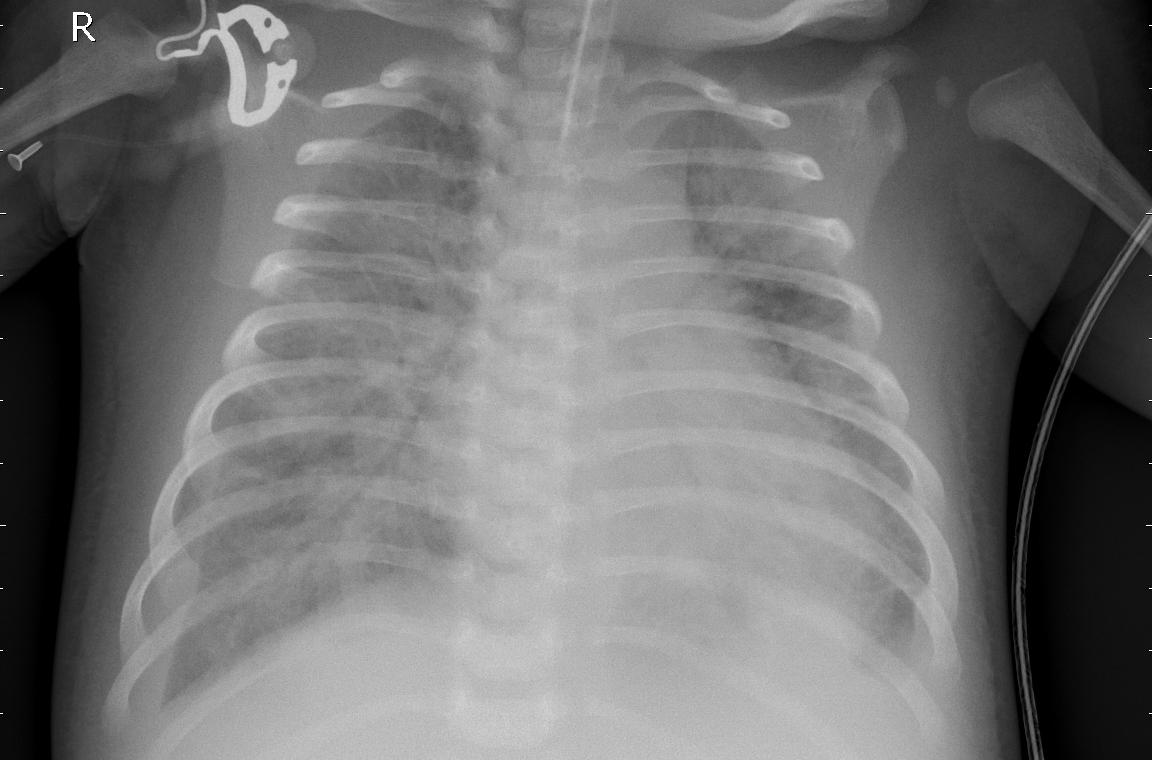

In [ ]:
cv2_imshow(img)

In [ ]:
#create the generator to load data from folders
datagen=ImageDataGenerator()

In [ ]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('/content/chest_xray/train', class_mode='binary', batch_size=32)
# load and iterate test dataset
test_it = datagen.flow_from_directory('/content/chest_xray/test', class_mode='binary', batch_size=32)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
unique, counts = np.unique(train_it.classes, return_counts=True)
normal=dict(zip(unique, counts))[0]
pneumonia=dict(zip(unique, counts))[1]

In [ ]:
print("normal classes :", normal)
print("pneumonia classes :", pneumonia)

normal classes : 1341
pneumonia classes : 3875


The data are not balanced

In [ ]:
#DATA IMBALANCE
N=10
dir="/content/chest_xray/train/NORMAL/"
list_files=os.listdir(dir)
for i in range (pneumonia-normal):
  file=random.choice(list_files)
  img=cv2.imread(dir+file)
  new_file=''.join(random.choice(string.ascii_lowercase + string.digits) for _ in range(N))
  new_path=dir+new_file+".jpeg"
  cv2.imwrite(new_path,img)


In [ ]:
#create the generator to load data from folders and perform data augmentation
datagen=ImageDataGenerator(horizontal_flip=True,shear_range=0.1)

In [ ]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('/content/chest_xray/train', class_mode='binary', batch_size=32)
# load and iterate validation dataset
val_it = datagen.flow_from_directory('/content/chest_xray/val', class_mode='binary', batch_size=32)
# load and iterate test dataset
test_it = datagen.flow_from_directory('/content/chest_xray/test', class_mode='binary', batch_size=32)

Found 7750 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
unique, counts = np.unique(train_it.classes, return_counts=True)
normal=dict(zip(unique, counts))[0]
pneumonia=dict(zip(unique, counts))[1]
print("normal classes :", normal)
print("pneumonia classes :", pneumonia)

normal classes : 3875
pneumonia classes : 3875


The data is balanced now

In [ ]:
train_it.image_shape

(256, 256, 3)

In [ ]:
#mount google drive to save the model
from google.colab import drive
drive.mount('/content/drive')

# Creating the model

In this model we use Xception as a pretrained model followed by fully connected layers 

We add some dropout,batchnormalization to avoid overfitting

In [ ]:
#Loading Xception pre-trained on ImageNet
tf.keras.applications.I
eff=tf.keras.applications.xception.Xception(include_top=False,input_shape=(300,300,3))
eff.trainable=False #setting Xception to be non-trainable
model=Sequential()
model.add(Input(shape=[None,None,3])) #adding Input layer
model.add(Resizing(height=300,width=300)) #adding resize layer
model.add(Rescaling(1/255)) #adding rescale layer
model.add(eff)
model.add(Flatten()) 
model.add(Dense(8))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(1,activation="sigmoid"))

#we use adam as optimizer which is considered the best in such problems
#binaryCrossEntropy as loss function
# and three metrics : accuracy, precision, recall 
model.compile(optimizer='adam',loss=BinaryCrossentropy(),metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 300, 300, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 300, 300, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 8)                 1638408   
                                                                 
 batch_normalization_4 (Batc  (None, 8)                32        
 hNormalization)                                         

# Training the model

In [ ]:
import time #to calculate the training time
start=time.time()
hist=model.fit_generator(train_it, validation_data=val_it,epochs=1)
end=time.time()
print("execution time :",end-start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


243/243 [==============================] - 2165s 9s/step - loss: 0.1233 - accuracy: 0.9583 - precision: 0.9652 - recall: 0.9510 - val_loss: 0.2752 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000
execution time : 2183.4617116451263


In [ ]:
#save the model in the drive
model.save("/content/drive/MyDrive/Pneumonia.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
#evaluate the model
result=model.evaluate_generator(test_it)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


In [ ]:
print('accuracy in test dataset: ',round(result[1]*100,2) ,"%")
print('precision in test dataset: ',round(result[2]*100,2) ,"%")
print('recall in test dataset: ',round(result[3]*100,2) ,"%")
print('f1-score in test dataset: ',round(((result[2]*result[3])/(result[2]+result[3]))*100*2,2) ,"%")

accuracy in test dataset:  84.13 %
precision in test dataset:  80.5 %
recall in test dataset:  98.46 %
f1-score in test dataset:  88.58 %


we search now for the F1-score of the two classes

In [ ]:
model=load_model("/content/drive/MyDrive/Pneumonia.h5")

In [ ]:
y_pred=[]
y_true=[]
for batch in test_it:
  y_true.extend(batch[1])
  pred=model.predict(batch[0])
  y_pred.extend([1 if i[0]>0.5 else 0 for i in pred])

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true,y_pred,average=None)

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20

In [ ]:
#calsses of the data 
classes=val_it.class_indices
classes

{'NORMAL': 0, 'PNEUMONIA': 1}

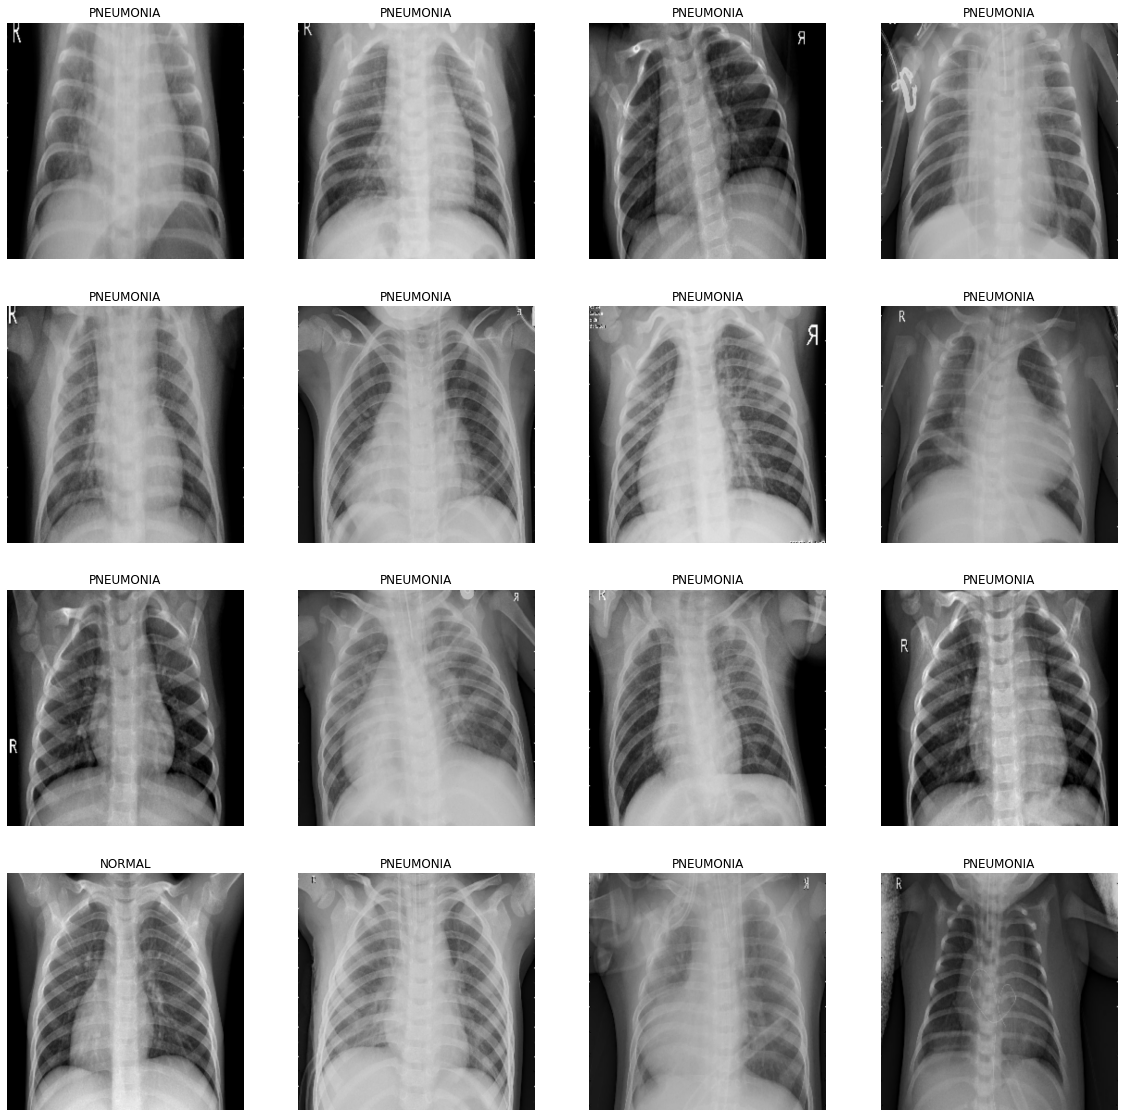

In [ ]:
j=0
n=4 #display n^2 image
for b in test_it:
  batch=np.array(b[0])
  for img in batch:
    if(j<n**2):
      display =cv2.resize(img, (500, 500),interpolation = cv2.INTER_AREA)
      plt.subplot(n,n,j+1)
      plt.axis('off')
      plt.imshow(display.astype(np.uint8))
      img=np.expand_dims(img,axis=0)
      prediction=model.predict(img)
      plt.title("NORMAL" if  prediction[0][0]<0.5 else 'PNEUMONIA')
      j+=1

    
  break

plt.show()

In [ ]:
x=cv2.imread("/content/pnuemonia.jpg")

In [ ]:
x=np.expand_dims(x,axis=0)
x.shape

In [ ]:
model.predict(x)